# Generate GeoJSON from Natural Earth Data

# Generate GeoJSON from Natural Earth Data

## Install Dependencies

```
pip install geopandas shapely matplotlib
```

## Download Data

Download datasets (_Admin 0 - Countries_ in [1:10](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/), and _Admin 1 – States, Provinces_ in 1:10 and [1:50](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/)) from Natural Earch Data:

In [1]:
# Dependencies

import os
import json
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import pandas as pd
import shapely.geometry
import shapely.ops
import shapely.affinity
from shapely.geometry import Polygon, MultiPolygon
import shutil

In [2]:
data_dir = os.path.expanduser("~/Downloads")
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

def download_files(skip_existing: bool):
    for url in [
        "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip",
        "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_1_states_provinces.zip",
        "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_1_states_provinces.zip"
    ]:
        file_name = url.split('/')[-1]
        full_file_name = f'{data_dir}/{file_name}'
        # temporary fix
        url = url.replace("https://www.naturalearthdata.com/http//www.naturalearthdata.com/download", "https://naciscdn.org/naturalearth")
        with requests.get(
            url,
            headers={
                "accept-encoding": "gzip, deflate, br",
                "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36"
            },
            stream=True,
        ) as res:
            file_size = int(res.headers['content-length'])
            if res.status_code != 200:
                print("Error downloading files. Please open the URL to download them from browser manually.")
                break
            if (
                skip_existing and
                os.path.exists(full_file_name) and
                file_size == os.path.getsize(full_file_name)
            ):
                print(f"Skip {file_name} because it already exists")
                continue
            print(f"Downloading {file_name}... \r", end="")
            with open(full_file_name, "wb") as fh:
                fh.write(res.content)
    print("Done.                                                            ")

download_files(skip_existing=False)

Done.                                                            


In [3]:
# Read Natural Earth data files into GeoDataFrames
df_admin0_10m = gpd.read_file(f"{data_dir}/ne_10m_admin_0_countries.zip")
df_10m = gpd.read_file(f"{data_dir}/ne_10m_admin_1_states_provinces.zip")
df_50m = gpd.read_file(f"{data_dir}/ne_50m_admin_1_states_provinces.zip")

# Convert column names to lowercase
df_admin0_10m.columns = df_admin0_10m.columns.str.lower()

# Download and load the GeoJSON file for India
india_geojson_url = "https://github.com/geohacker/india/raw/bcb920c7d3c686f01d085f7661c9ba89bf9bf65e/state/india_state_kashmir_ladakh.geojson"

try:
    india_gdf = gpd.read_file(india_geojson_url)
    print("GeoJSON file for India downloaded and loaded successfully.")
except Exception as e:
    print(f"Unable to download or load the GeoJSON file for India. Error: {str(e)}")
    print("Please download the file from the URL and try again.")

GeoJSON file for India downloaded and loaded successfully.


In [4]:
df_50m.groupby('admin').count()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
admin,,,,,,,,,,,,,,,,,,,,,
Australia,9,9,9,9,9,0,9,9,9,0,...,0,0,0,0,0,0,0,0,0,9
Brazil,27,27,27,27,27,0,27,27,27,13,...,0,0,0,0,0,0,0,0,0,27
Canada,13,13,13,13,13,13,13,13,13,9,...,0,0,0,0,0,0,0,0,0,13
China,31,31,31,31,31,0,31,31,31,30,...,0,0,0,0,0,0,0,0,0,31
India,36,36,36,36,36,0,36,36,36,13,...,0,0,0,0,0,0,0,0,0,36
Indonesia,33,33,33,33,33,0,33,33,33,30,...,0,0,0,0,0,0,0,0,0,33
Russia,85,85,85,85,85,1,85,85,85,84,...,0,0,0,0,0,0,0,0,0,85
South Africa,9,9,9,9,9,0,9,9,9,9,...,0,0,0,0,0,0,0,0,0,9
United States of America,51,51,51,51,51,51,51,51,51,51,...,0,0,0,0,0,0,0,0,0,51


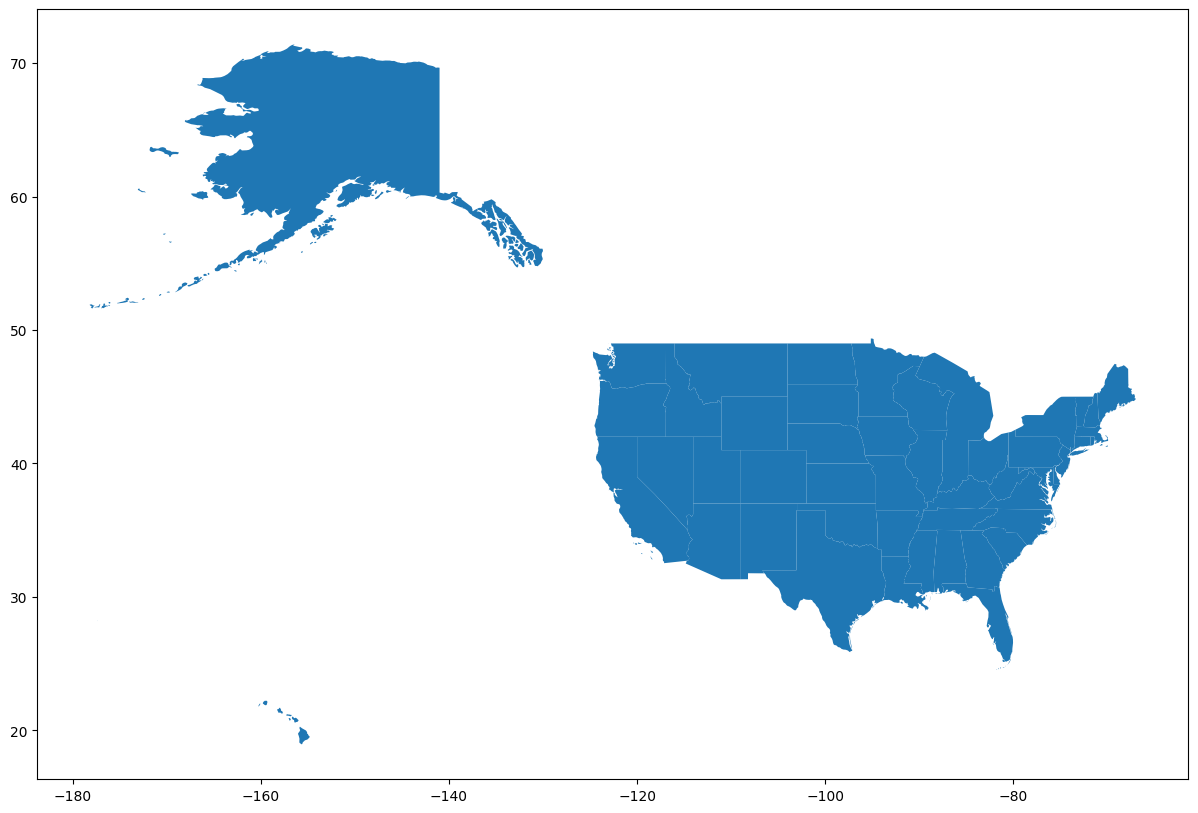

<Axes: >

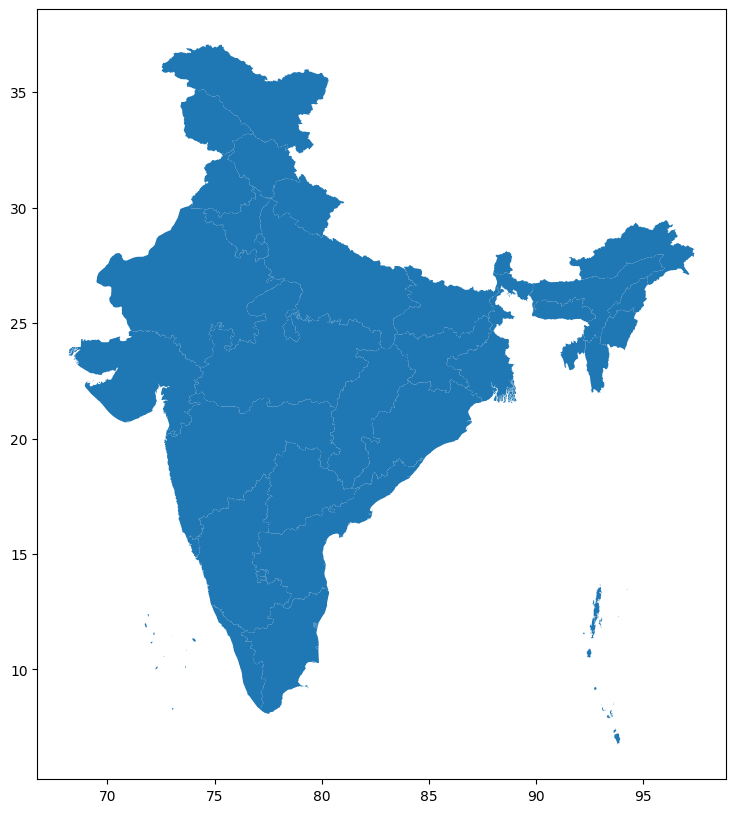

In [5]:
df_50m[df_50m.adm0_a3 == 'USA'].plot(figsize=(20,10))
plt.show()

india_gdf.plot(figsize=(20, 10))

In [6]:
# Use 1:50m geometry for some large countries:

print(*df_50m['admin'].unique(), sep='\n')

Australia
Brazil
Canada
United States of America
China
India
Indonesia
Russia
South Africa


In [7]:
df = pd.concat([df_10m[~df_10m['admin'].isin(df_50m['admin'].unique())], df_50m])

## Adjust the Maps

<span style="color: red; font-size: 1.5em">TO SUPPORT NEW COUNTRIES, ADD COUNTRY NAME BELOW</span>

In [8]:
# Country names used in file names
countries = [
  'afghanistan',
  # 'aland islands',
  'albania',
  'algeria',
  'american samoa',
  'andorra',
  'angola',
  'anguilla',    
  'antarctica',
  # 'antigua and Barbuda',
  'argentina',
  'armenia',
  'aruba',
  'australia',
  'austria',
  'azerbaijan',
  # 'bahamas (the)',
  'bahrain',
  'bangladesh',
  'barbados',
  'belarus',
  'belgium',
  'belize',
  'benin',
  'bermuda',
  'bhutan',
  'bolivia',
  # 'bonaire, sint eustatius and saba',
  'bosnia and herzegovina',
  'botswana',
  # 'bouvet island',
  'brazil',
  'brunei',
  'british indian ocean territory',
  'bulgaria',
  'burkina faso',
  'burundi',
  # 'cabo verde',
  'cambodia',
  'cameroon',
  'canada',
  'cayman islands',
  'central african republic',
  'chad',
  'chile',
  'china',
  # 'christmas island',
  # 'cocos (keeling) islands', # keeling
  'colombia',
  'comoros',
  'democratic republic of the congo',
  # 'the congo',
  'cook islands',
  'costa rica',
  # 'côte d\'ivoire',
  'croatia',
  'cuba',
  'curaçao',
  'cyprus',
  'czech republic',
  'denmark',
  'djibouti',
  'dominica',
  'dominican republic',
  'ecuador',
  'egypt',
  'el salvador',
  'equatorial guinea',
  'eritrea',
  'estonia',
  # 'eswatini',
  'ethiopia',
  'falkland islands',
  'faroe islands',
  'fiji',
  'finland',
  'france',
  # 'french guiana',
  'french polynesia',
  # 'french southern territories (the)',
  'gabon', 
  'gambia',
  'germany',
  'ghana',
  'gibraltar',
  'greece',
  'greenland',
  'grenada',
  # 'guadeloupe',
  'guam',
  'guatemala',
  'haiti',
  # 'holy see (the)',
  'guernsey',
  'guinea',
  # 'guinea-bissau',
  'guyana',
  'honduras',
  'iceland',
  'india',
  'indonesia',
  'iran',
  'italy',
  'japan',
  'jordan',
  'kazakhstan',
  'kenya',
  'korea',
  'kuwait',
  'kyrgyzstan',
  # 'lao people\'s democratic republic (the)',
  'latvia',
  'lebanon',
  'lesotho',
  'liberia',
  'libya',
  'liechtenstein',
  'lithuania',
  'luxembourg',
  # 'macao',
  'macedonia',
  'madagascar',
  'malawi',
  'malaysia',
  'maldives',
  'mali',
  'malta',
  'marshall islands',
  # 'martinique',
  'mauritania',
  'mauritius',
  # 'mayotte',
  'mexico',
  'moldova',
  'montserrat',
  'monaco',
  'mongolia',
  'montenegro',
  'morocco',
  'mozambique',
  'myanmar',
  'namibia',
  'nauru',
  'nepal',
  'netherlands',
  'new caledonia',
  'new zealand',
  'nicaragua',
  'niger',
  'nigeria',
  'niue',
  'norfolk island',
  'northern mariana islands',
  'norway',
  'oman',
  'pakistan',
  'palau',
  # 'palestine',
  'panama',
  'papua new guinea',
  'paraguay',
  'peru',
  # 'pitcairn',
  'philippines',
  'poland',
  'portugal',
  'puerto rico',
  'qatar',
  # 'réunion',
  'romania',
  'russia',
  'rwanda',
  'saint barthelemy',
  # 'saint helena, ascension and tristan da cunha',
  'saint lucia',
  'saint martin',
  # 'saint martin (french part)',
  'saint pierre and miquelon',
  'saint vincent and the grenadines',
  'samoa',
  'san marino',
  'sao tome and principe',
  'saudi arabia',
  'senegal',
  # 'serbia',
  'seychelles',
  'sierra leone',
  'singapore',
  # 'sint maarten (dutch part)',
  'slovakia',
  'slovenia',
  'solomon islands',
  'somalia',
  'south africa',
  # 'south sudan',
  'spain',
  'sri lanka',
  'sudan',
  'suriname',
  # 'svalbard and jan mayen',
  'sweden',
  'switzerland',
  'syria',
  'taiwan',
  'tajikistan',
  'tanzania',
  'thailand',
  'timorleste',
  'togo',
  # 'tokelau',
  'tonga',
  'trinidad and tobago',
  'tunisia',
  'turkey',
  'turkmenistan',
  'turks and caicos islands',
  'tuvalu',
  'uganda',
  'uk',
  'ukraine',
  'united arab emirates',
  'united states minor outlying islands',
  'uruguay',
  'usa',
  'uzbekistan',
  'vanuatu',
  'venezuela',
  'vietnam',
  # 'virgin islands (british)',
  # 'virgin islands (u.s.)',
  'wallis and futuna',
  'yemen',
  'zambia',
  'zimbabwe'
]

# country name used in dataset
country_name_aliases = {
    "uk": "united kingdom",
    "usa": "united states of america",
    "korea": "south korea",
    "timorleste": "east timor",
    "tanzania": "united republic of tanzania",
}

# CSV files that are defined later in the notebook:
custom_countries = [
  'france_regions',
  'italy_regions',
  'philippines_regions',
  'turkey_regions'
]

# Make sure all country names are covered:
invalid_countries = [x for x in countries if (country_name_aliases.get(x, x) not in df["admin"].str.lower().unique()) and (x not in custom_countries)]

if invalid_countries:
  print(f"Following country names are not valid: {invalid_countries}")

Preview all countries:

/var/folders/qb/g_y12hgx11q6zfl1y75kmn2c0000gn/T/ipykernel_84809/1280406611.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


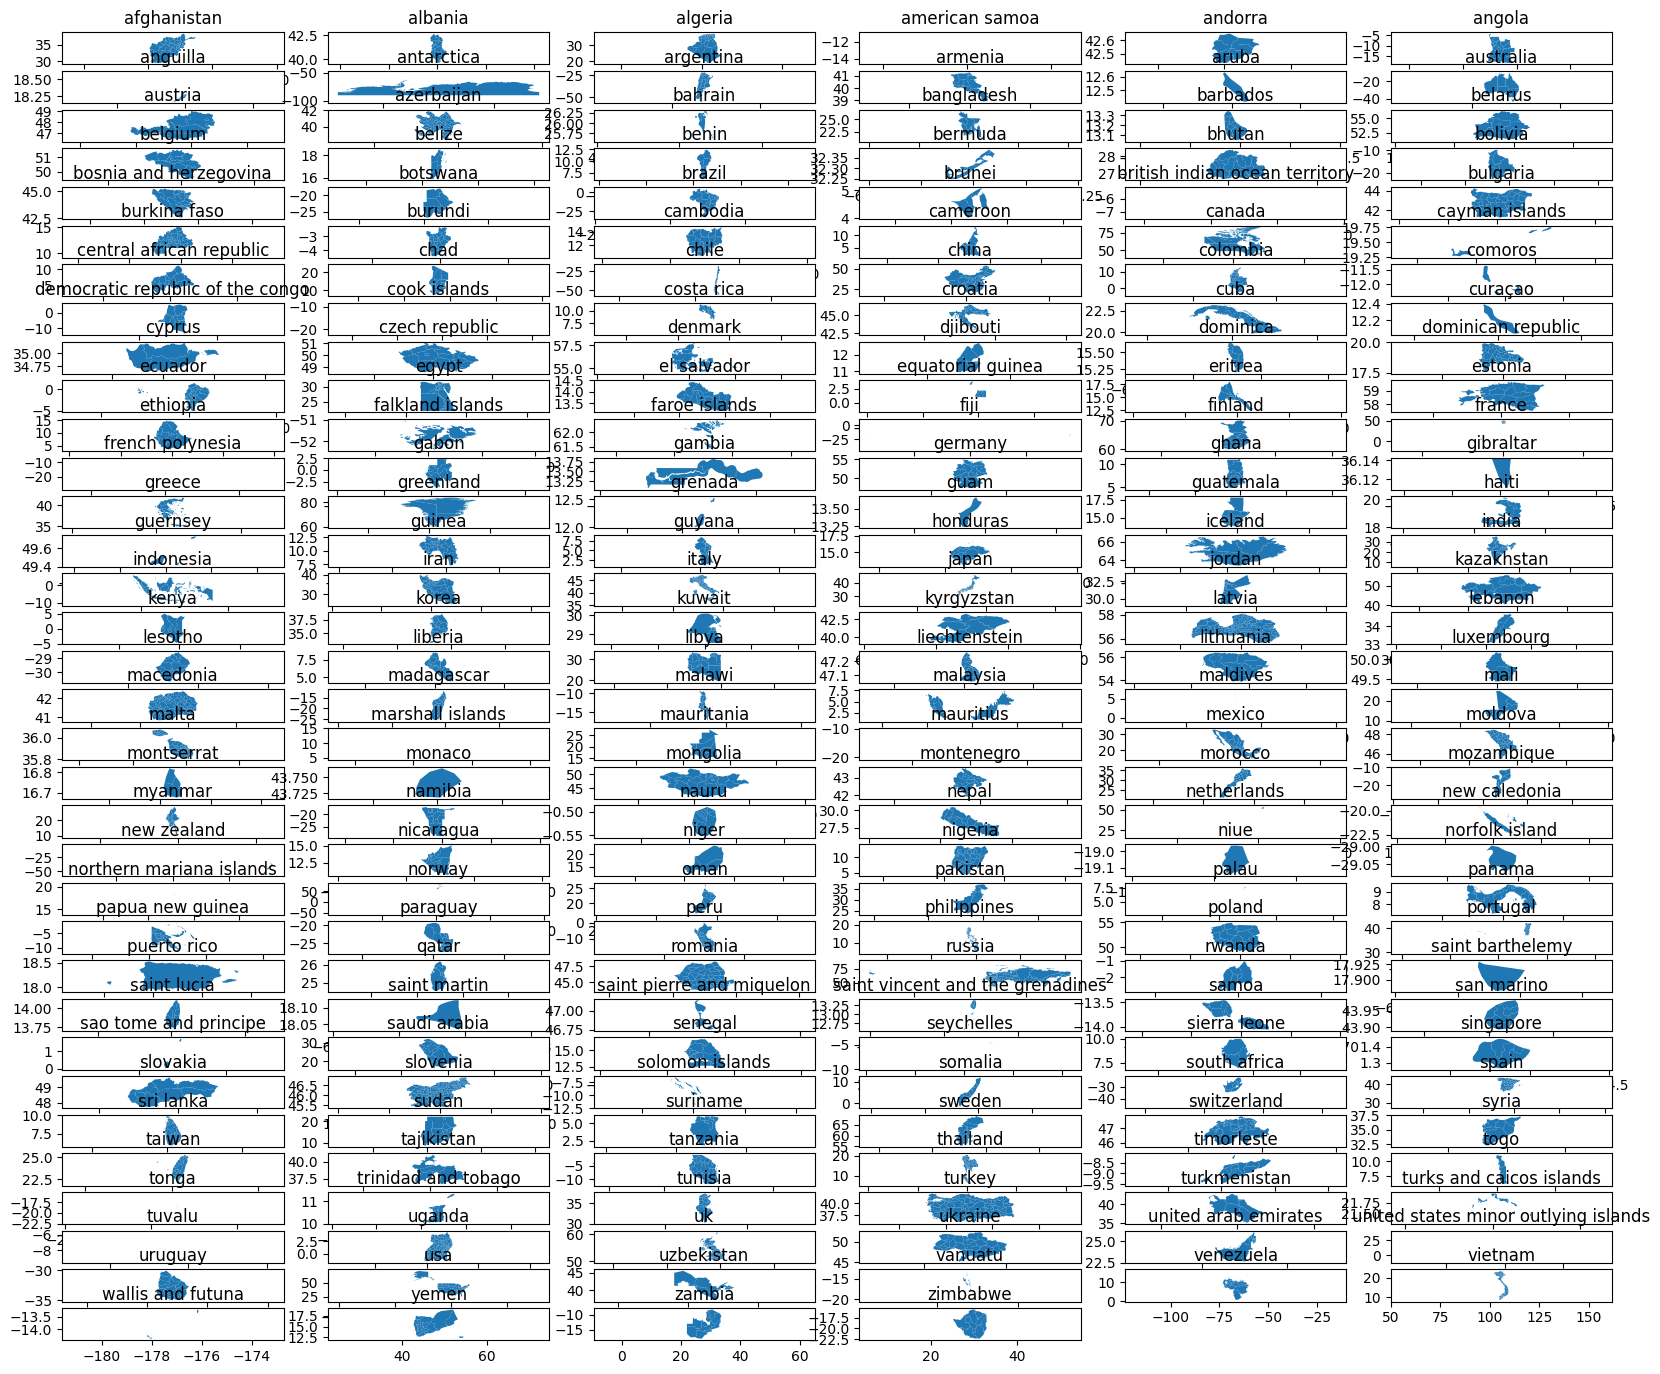

In [9]:
alt_maps = dict()

def get_gdf(country):
    country_alias = country_name_aliases.get(country, country)
    if country in alt_maps:
        gdf = alt_maps[country]
    elif country in custom_countries:
        gdf = gpd.read_file(f'../src/countries_custom/{country}.geojson')
    else:
        gdf = df[df["admin"].str.lower() == country_alias]
    return gdf.copy()

def plot_all_countries():
    plt.figure(figsize=(20, 20))

    for i, country in enumerate(countries):
        # create subplot axes in a 3x3 grid
        ax = plt.subplot(len(countries) // 5, 6, i + 1) # nrows, ncols, axes position
        gdf = get_gdf(country)
        if not gdf.empty:  # check if GeoDataFrame is not empty
            gdf.plot(ax=ax)
            ax.set_aspect('equal', adjustable='datalim')
        else:  # if GeoDataFrame is empty
            ax.text(0.5, 0.5, country, ha='center', va='center')  # add country name to the center of the subplot
        ax.set_title(country)

    # plt.tight_layout()
    plt.show()

plot_all_countries()

### Handle countries with flying islands

- For countries with flying islands, we need to move the islands closer to the mainland.

#### USA

<Axes: >

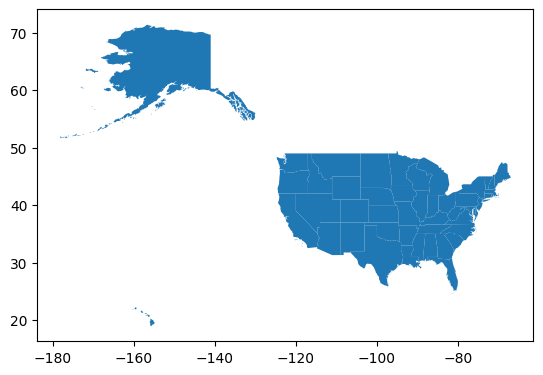

In [10]:
usa = df[df['adm0_a3'] == 'USA']
usa.plot()

<Axes: >

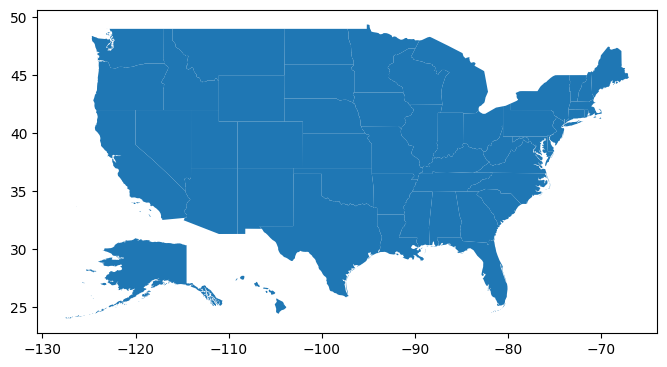

In [11]:
def reposition(df, idx, xoff=None, yoff=None, xscale=None, yscale=None, simplify=None):

    def move_and_scale(series):
        if xoff or yoff:
            series = shapely.affinity.translate(series, xoff or 0, yoff or 0)
        if xscale or yscale:
            series = shapely.affinity.scale(series, xscale or 1, yscale or 1)
        if simplify:
            series = series.simplify(simplify, preserve_topology=False)
        return series

    df.loc[idx, 'geometry'] = df.loc[idx, 'geometry'].apply(move_and_scale)


usa_copy = usa.copy()
reposition(usa_copy, usa.name == 'Hawaii', 51, 5.5)
reposition(usa_copy, usa.name == 'Alaska', 35, -34, 0.35, 0.35)

usa_copy.plot(figsize=(8,8))

#### China

China claims sovereign over Taiwan. For disputed territories, we respect each country and give them what they want.

In addition, Hong Kong and Macau should also be included in a China map.

In [12]:
# Chinese Special Administrative Regions
china_sars = df_admin0_10m.loc[
    df_admin0_10m.name_en.isin(['Taiwan', 'Hong Kong', 'Macau']),
    [x for x in df_admin0_10m.columns if x in df.columns]
]
china_sars = china_sars.merge(pd.DataFrame(
    data={
        "name_en": ["Taiwan", "Hong Kong", "Macau"],
        "name_zh": ["中国台湾", "香港特别行政区", "澳门特别行政区"],
        "iso_3166_2": ["CN-71", "CN-91", "CN-92"],
    },
), on="name_en", how="left")
china_sars

,featurecla,scalerank,labelrank,sov_a3,type,admin,adm0_a3,gu_a3,name,abbrev,...,name_sv,name_tr,name_uk,name_ur,name_vi,name_zh_x,name_zht,geometry,name_zh_y,iso_3166_2
0,Admin-0 country,0,4,CH1,Country,Hong Kong S.A.R.,HKG,HKG,Hong Kong,H.K.,...,Hongkong,Hong Kong,Гонконг,ہانگ کانگ,Hồng Kông,香港,香港,"MULTIPOLYGON (((114.22983 22.55581, 114.23471 ...",香港特别行政区,CN-91
1,Admin-0 country,0,3,TWN,Sovereign country,Taiwan,TWN,TWN,Taiwan,Taiwan,...,Taiwan,Çin Cumhuriyeti,Республіка Китай,تائیوان,Đài Loan,中华民国,中華民國,"MULTIPOLYGON (((121.90577 24.95010, 121.83473 ...",中国台湾,CN-71
2,Admin-0 country,0,4,CH1,Country,Macao S.A.R,MAC,MAC,Macao,Mac.,...,Macao,Makao,Аоминь,مکاؤ,Ma Cao,澳门,澳門,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ...",澳门特别行政区,CN-92


<Axes: >

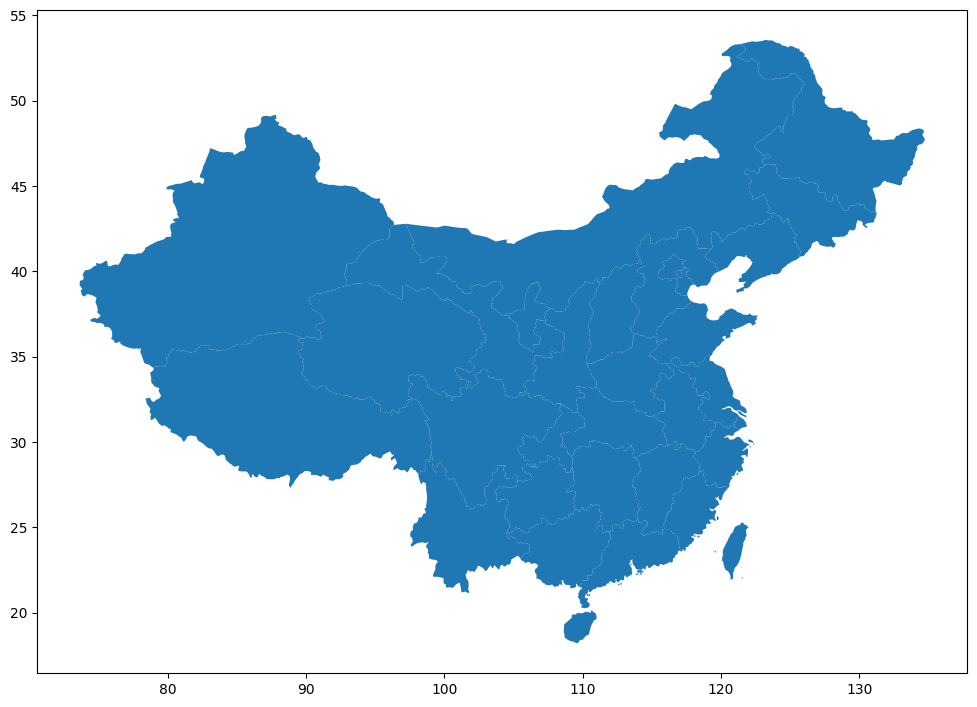

In [13]:
china = df[df.admin == "China"]
china_copy = pd.concat([china, china_sars], ignore_index=True)

# Combine the 'name_zh' columns
china_copy["name_zh"] = china_copy["name_zh"].combine_first(china_copy["name_zh_y"])

# Drop the extra 'name_zh_x' and 'name_zh_y' columns, if they exist
china_copy = china_copy.drop(["name_zh_x", "name_zh_y"], axis=1)

# Plotting the DataFrame
china_copy.plot(figsize=(12, 12))

Note [ISO-3166-2:CN](https://en.wikipedia.org/wiki/ISO_3166-2:CN) has updated subdivisions to use letters instead of numbers (e.g. `CN-91` -> `CN-HK`). We kept the numeric code for backward compatibility.

#### Finland

- The Åland Islands (ISO country code AX) is an autonomous region of Finland, and carries the ISO-3166 code FI-01.

In [14]:
finland_aland = df_admin0_10m.loc[
    df_admin0_10m.name_en.isin(['Åland']),
    [x for x in df_admin0_10m.columns if x in df.columns]
]
finland_aland = finland_aland.merge(pd.DataFrame(
    data={
        "name_en": ["Åland"],
        "name_fi": ["Ahvenanmaan maakunta"],
        "iso_3166_2": ["FI-01"],
    },
), on="name_en", how="left")


<Axes: >

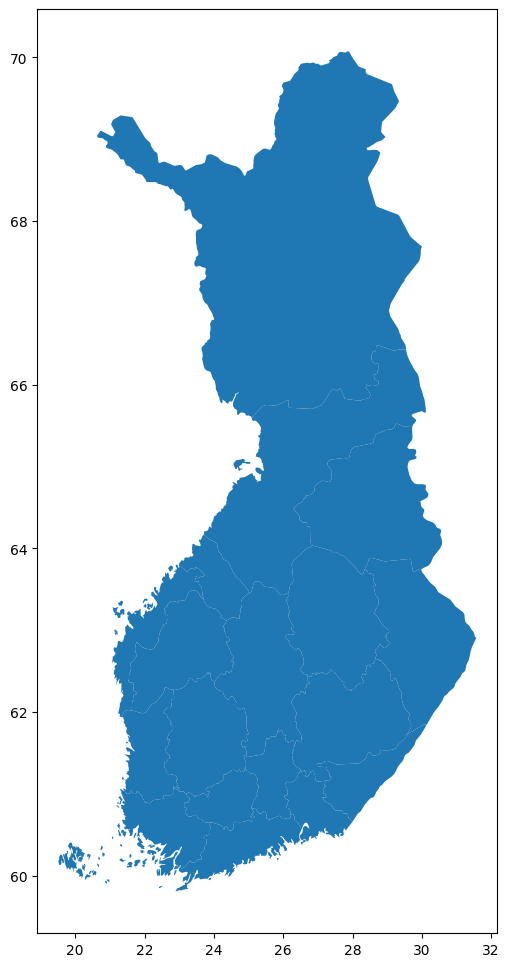

In [15]:
finland = df[df.admin == "Finland"]

# Concatenate the 'finland' DataFrame with 'finland_aland' DataFrame
finland_copy = pd.concat([finland, finland_aland], ignore_index=True)

# Combine 'name_fi' columns. However, since both columns are named 'name_fi', this might be redundant
# If you have two different columns for 'name_fi' values in each DataFrame, specify them as 'name_fi_x' and 'name_fi_y'
finland_copy["name_fi"] = finland_copy["name_fi"].combine_first(finland_copy["name_fi"])

# Drop the 'name_fi' column, if that's intended. This will remove the 'name_fi' data entirely.
# If you meant to drop other columns (like 'name_fi_x' and 'name_fi_y'), update the column names accordingly
finland_copy = finland_copy.drop(["name_fi"], axis=1)

# Plotting the DataFrame
finland_copy.plot(figsize=(12, 12))


#### Ukraine

- Crimea, carrying ISO-3166 code UA-43, belongs to Ukraine (ISO country code UA)

<Axes: >

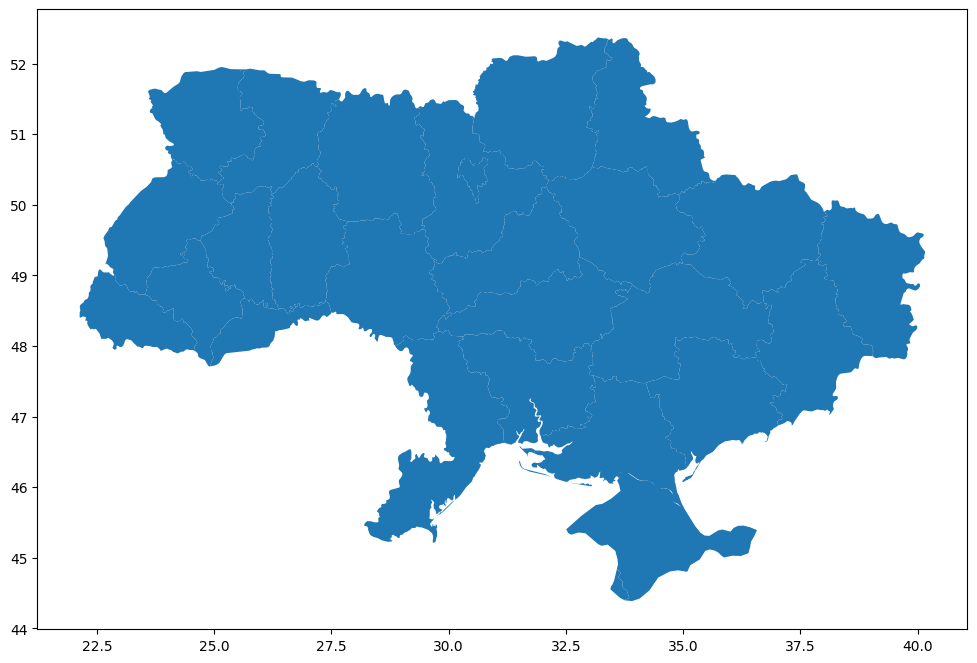

In [16]:

russia_copy = df[df['adm0_a3'] == 'RUS'].copy()
crimea = russia_copy[russia_copy['iso_3166_2'] == 'UA-43'].copy()
sevastopol = russia_copy[russia_copy['iso_3166_2'] == 'UA-40'].copy()

ukraine_with_crimea = pd.concat([df[df['adm0_a3'] == 'UKR'], crimea, sevastopol], ignore_index=True)

# kyiv = ukraine_with_crimea[ukraine_with_crimea['iso_3166_2'] == 'UA-30']
# kyiv_oblast = ukraine_with_crimea[ukraine_with_crimea['iso_3166_2'] == 'UA-32']

# Update the name of the Kyiv city entry
ukraine_with_crimea.loc[ukraine_with_crimea['iso_3166_2'] == 'UA-30', 'name'] = 'Kyiv'

# # Update the name of the Kyiv Oblast entry
ukraine_with_crimea.loc[ukraine_with_crimea['iso_3166_2'] == 'UA-32', 'name'] = 'Kyiv Oblast'

# Plotting the DataFrame
ukraine_with_crimea.plot(figsize=(12, 12))

#### Norway

- Remove NO-X01~ (The uninhabited Bouvet Island) and move Svalbard closer to mainland

<Axes: >

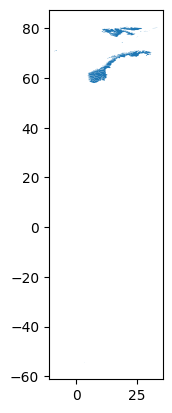

In [17]:
norway = df[df['adm0_a3'] == 'NOR']
norway.plot()

<Axes: >

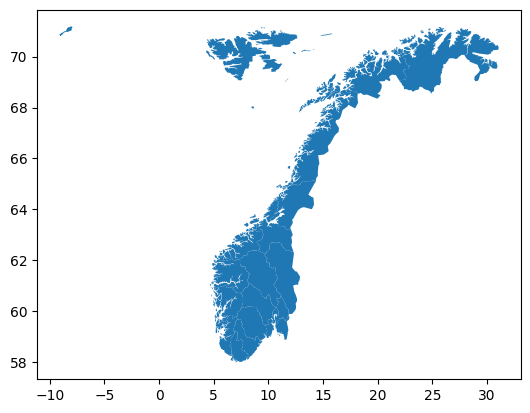

In [18]:
norway_copy = norway.copy()

norway_copy = norway_copy[norway_copy["iso_3166_2"] != "NO-X01~"]
reposition(norway_copy, norway.name == 'Svalbard', -12, -8, 0.5, 0.5)
#reposition(norway_copy, norway.name == 'Nordland', 10, 0, 2, 2)

norway_copy.plot()

#### Portugal

<Axes: >

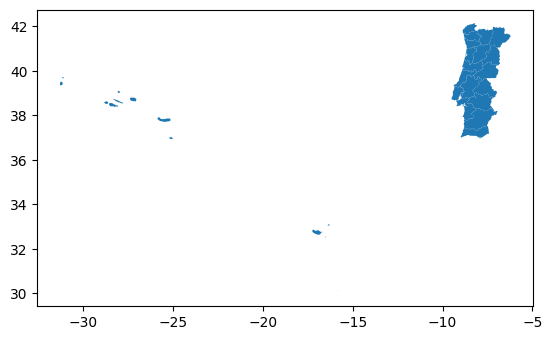

In [19]:
portugal = df[df.admin == 'Portugal']
portugal.plot()

<Axes: >

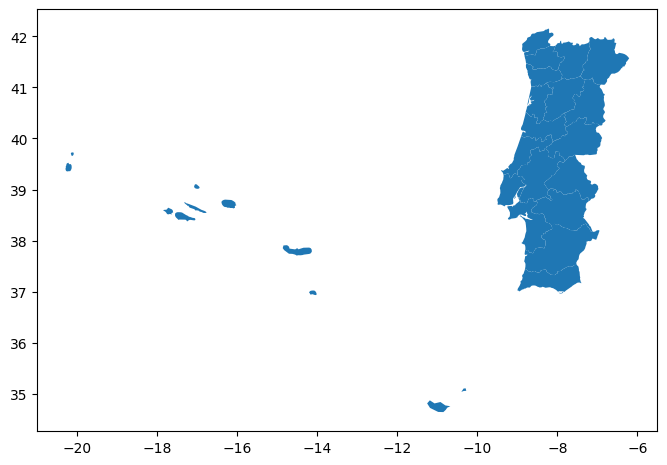

In [20]:
portugal_copy = portugal.copy()

reposition(portugal_copy, portugal.name == 'Azores', 11, 0)
reposition(portugal_copy, portugal.name == 'Madeira', 6, 2, simplify=0.015)

portugal_copy.plot(figsize=(8, 8))

#### Spain

<Axes: >

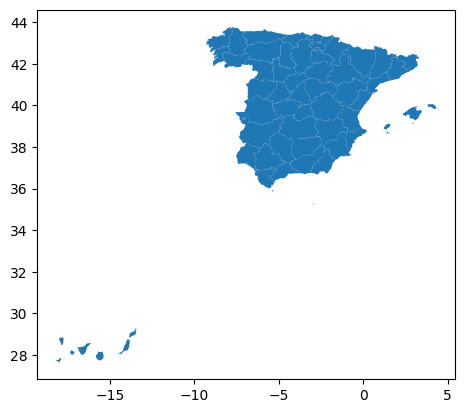

In [21]:
spain = df[df.admin == 'Spain']
spain.plot()

<Axes: >

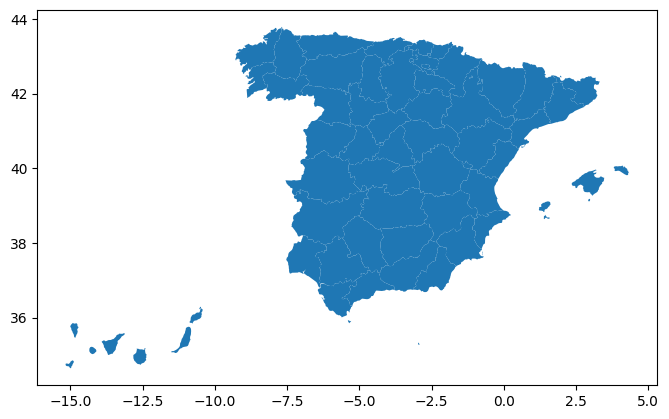

In [22]:
spain_copy = spain.copy()

reposition(spain_copy, spain.name.isin(['Las Palmas', 'Santa Cruz de Tenerife']), 3, 7, 1, 1)

spain_copy.plot(figsize=(8, 8))

#### Russia

<Axes: >

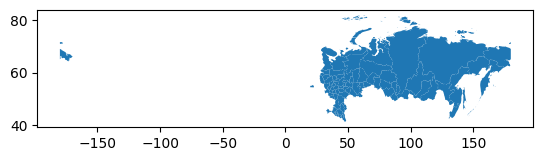

In [23]:
russia = df[df.admin == 'Russia']
russia.plot()

- Russia looks off because of Chukchi runs across E180. We need to move the parts on the other side of the map to the right.

<Axes: >

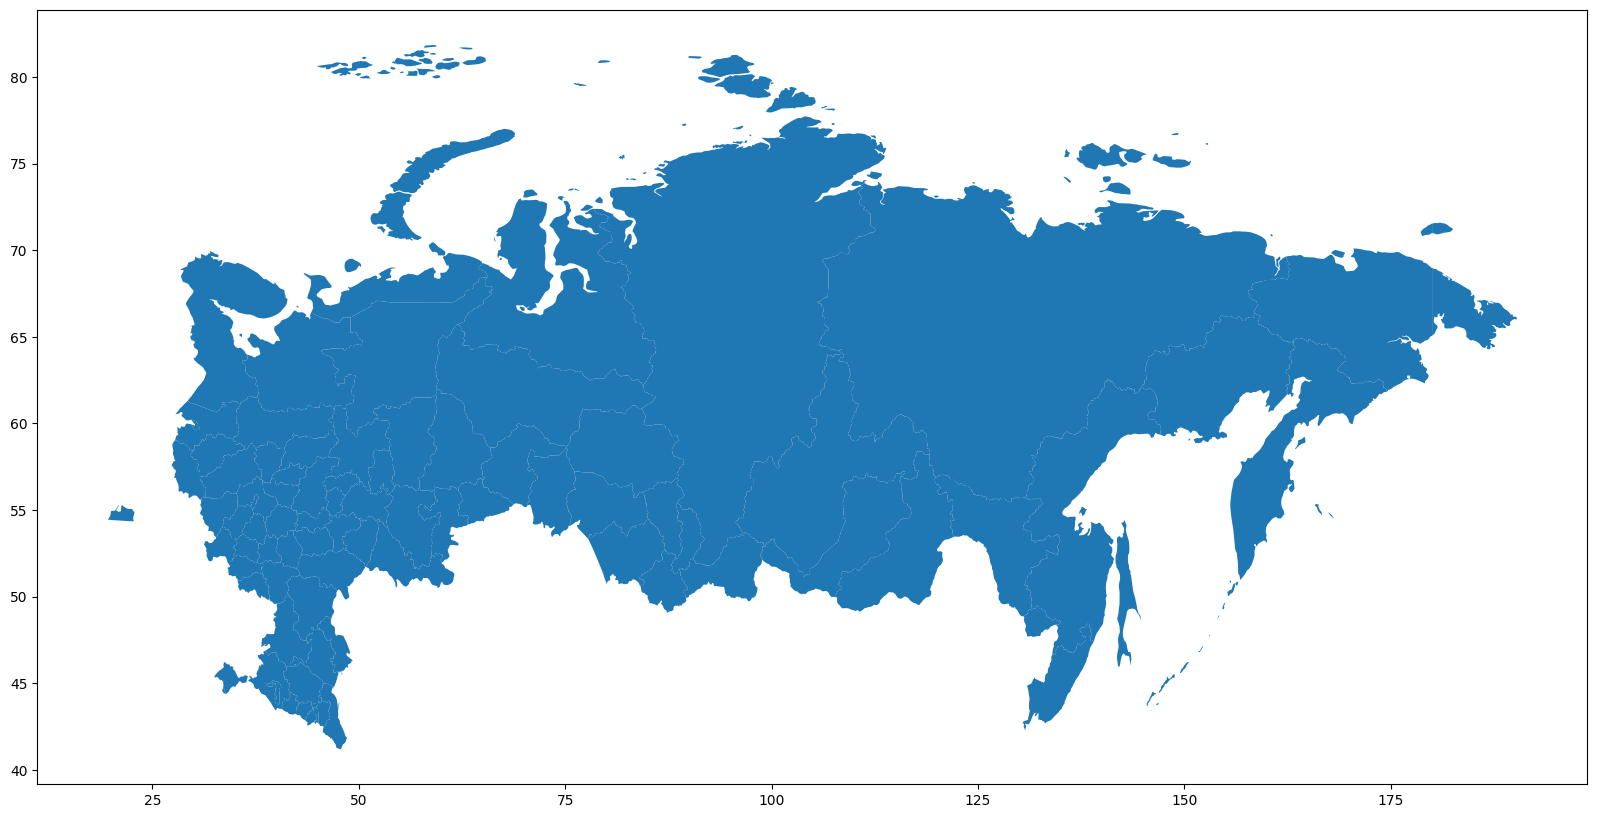

In [24]:
def shift_geom(geom, cutoff=0):
    border = shapely.geometry.LineString([(cutoff, -90), (cutoff, 90)])
    splitted_geom = shapely.ops.split(geom, border)

    # Create a list to store moved geometries
    moved_geom = []

    # Check if the split operation returned a GeometryCollection
    if isinstance(splitted_geom, shapely.geometry.GeometryCollection):
        # Iterate over each geometry in the GeometryCollection
        for item in splitted_geom.geoms:
            minx, miny, maxx, maxy = item.bounds
            if minx < cutoff:
                # Translate the geometry
                moved_geom.append(shapely.affinity.translate(item, xoff=360 - cutoff))
            else:
                moved_geom.append(item)
    else:
        # If the result is not a GeometryCollection, it means no split occurred
        moved_geom.append(geom)

    # Combine all moved geometries into a single geometry
    return shapely.ops.unary_union(moved_geom)

# Applying the function to the DataFrame
russia_copy = russia.copy()
russia_copy.loc[
    russia.name == 'Chukchi Autonomous Okrug', 'geometry'
] = russia_copy.loc[
    russia.name == 'Chukchi Autonomous Okrug', 'geometry'
].apply(shift_geom)

# Plotting
russia_copy.plot(figsize=(20, 20))


### Turkey

#### Turkey Regions

<Axes: >

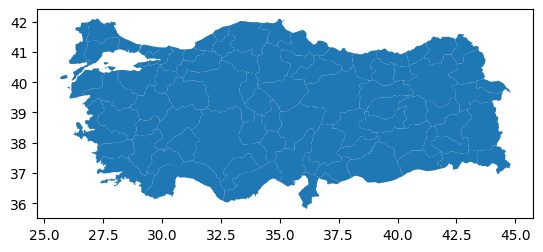

In [25]:
turkey = df[df.admin == 'Turkey'][['iso_3166_2','geometry']]
turkey.plot()

In [26]:
# NUTS - 1 Codes for Turkey and correspong region - city names

region_dict = {
 'TR1': ['TR-34'],
 'TR2': ['TR-59', 'TR-22', 'TR-39', 'TR-10', 'TR-17'],
 'TR3': ['TR-35', 'TR-09', 'TR-20', 'TR-48', 'TR-45', 'TR-03', 'TR-43', 'TR-64'],
 'TR4': ['TR-16', 'TR-26', 'TR-11', 'TR-41', 'TR-54', 'TR-81', 'TR-14', 'TR-77'],
 'TR5': ['TR-06', 'TR-42', 'TR-70'],
 'TR6': ['TR-07', 'TR-32', 'TR-15', 'TR-01', 'TR-33', 'TR-31', 'TR-46', 'TR-80'],
 'TR7': ['TR-71', 'TR-68', 'TR-51', 'TR-50', 'TR-40', 'TR-38', 'TR-58', 'TR-66'],
 'TR8': ['TR-67', 'TR-78', 'TR-74', 'TR-37', 'TR-18', 'TR-57', 'TR-55', 'TR-60', 'TR-19', 'TR-05'],
 'TR9': ['TR-61', 'TR-52', 'TR-28', 'TR-53', 'TR-08', 'TR-29'],
 'TRA': ['TR-25', 'TR-24', 'TR-69', 'TR-04', 'TR-36', 'TR-76', 'TR-75'],
 'TRB': ['TR-44', 'TR-23', 'TR-12', 'TR-62', 'TR-65', 'TR-49', 'TR-13', 'TR-30'],
 'TRC': ['TR-27', 'TR-02', 'TR-79', 'TR-63', 'TR-21', 'TR-47', 'TR-72', 'TR-73', 'TR-56']}

# Region names corresponding to NUTS-1

region_name_dict = {'TR1':'İstanbul',
                    'TR2':'Batı Marmara',
                    'TR3':'Ege',
                    'TR4':'Doğu Marmara',
                    'TR5':'Batı Anadolu',
                    'TR6':'Akdeniz',
                    'TR7':'Orta Anadolu',
                    'TR8':'Batı Karadeniz',
                    'TR9':'Doğu Karadeniz',
                    'TRA':'Kuzeydoğu Anadolu',
                    'TRC':'Güneydoğu Anadolu',
                    'TRB':'Ortadoğu Anadolu'
                    }


def create_region_polygons(region_dict, turkey_gdf):
    # Create a reverse dictionary where city codes map to region codes
    city_to_region = {city_code: region_code for region_code, city_codes in region_dict.items() for city_code in city_codes}

    # Create a new column 'REGION' in the GeoDataFrame that maps each city to its region
    turkey_gdf['REGION'] = turkey_gdf['iso_3166_2'].map(city_to_region)

    # Dissolve the GeoDataFrame on the 'REGION' column to combine city polygons into region polygons
    region_gdf = turkey_gdf.dissolve(by='REGION')

    # Reset the index of the new GeoDataFrame
    region_gdf.reset_index(inplace=True)
    
    return region_gdf.drop(columns=['iso_3166_2'])

In [27]:
turkey_regions = create_region_polygons(region_dict, turkey)

# Rename 'REGION' column to 'ISO'
turkey_regions = turkey_regions.rename(columns={'REGION': 'iso_3166_2'})

# Map the region_name_dict to a new 'NAME_1' column
turkey_regions['name'] = turkey_regions['iso_3166_2'].map(region_name_dict)

<Axes: >

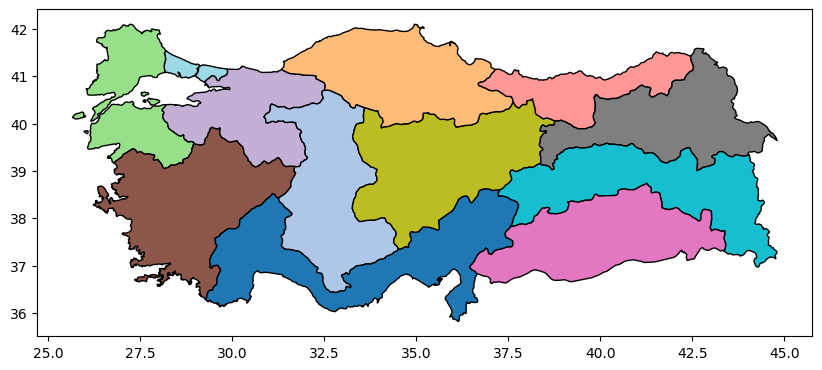

In [28]:
turkey_regions.plot(figsize=(10, 7), edgecolor='black', column='name', legend=False, cmap='tab20')

### France

<Axes: >

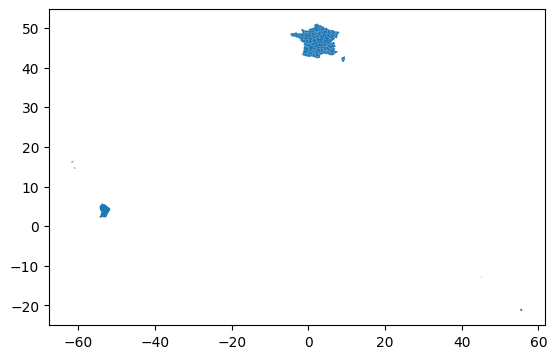

In [29]:
france = df[df.admin == 'France']
france.plot()

Move the [Overseas departments and regions of France](https://en.wikipedia.org/wiki/Overseas_departments_and_regions_of_France) closer to mainland.

Fix some department names

- Seien-et-Marne => Seine-et-Marne
- Haute-Rhin => Haut-Rhin

In [30]:
def replace_name(df, old, new):
    if old in list(df.name):  
        index = df[df.name == old].index[0]
        df.at[index, 'name'] = new
        
replace_name(france, 'Seien-et-Marne', 'Seine-et-Marne')
replace_name(france, 'Haute-Rhin', 'Haut-Rhin')

<Axes: >

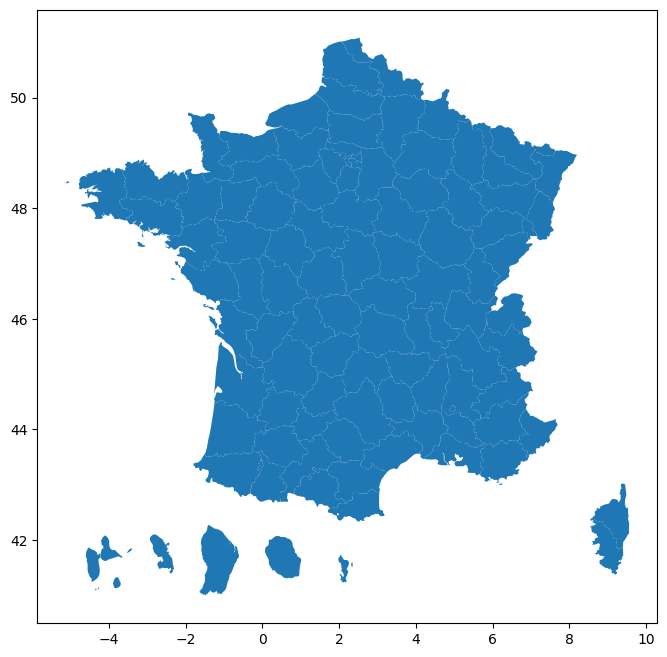

In [31]:
france_copy = france.copy()
reposition(france_copy, france.name=='Guadeloupe', 57.4, 25.4, 1.5, 1.5)
reposition(france_copy, france.name=='Martinique', 58.4, 27.1, 1.5, 1.5)
reposition(france_copy, france.name=='Guyane française', 52, 37.7, 0.35, 0.35)
reposition(france_copy, france.name=='La Réunion', -55, 62.8, 1.5, 1.5)
reposition(france_copy, france.name=='Mayotte', -43, 54.3, 1.5, 1.5)

france_copy.plot(figsize=(8, 8))

#### France Regions

In [32]:
france_regions = france_copy[['geometry','region_cod','region']]

In [33]:
france_regions = france_regions.dissolve(by=['region_cod', 'region']).reset_index()

france_regions = france_regions.rename(columns={'region': 'name', 'region_cod': 'iso_3166_2'})

<Axes: >

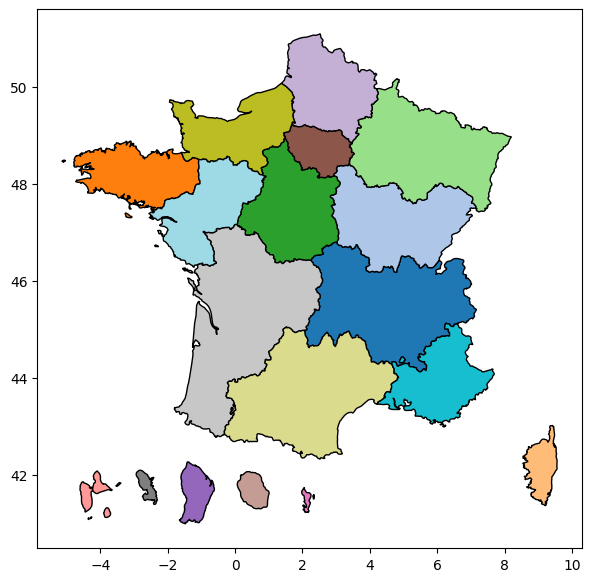

In [34]:
france_regions.plot(figsize=(10, 7), edgecolor='black', column='iso_3166_2', legend=False, cmap='tab20')

### Italy

#### Italy Regions

In [35]:
italy_regions = df[df.admin == 'Italy'][['geometry','region_cod','region']]

italy_regions = italy_regions.dissolve(by=['region_cod', 'region']).reset_index()

italy_regions = italy_regions.rename(columns={'region': 'name', 'region_cod': 'iso_3166_2'})

<Axes: >

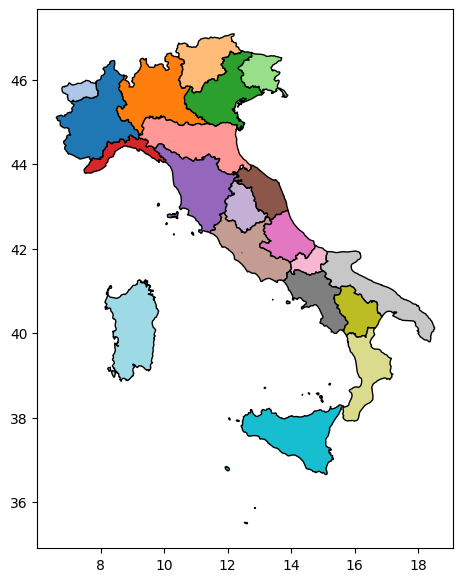

In [36]:
italy_regions.plot(figsize=(10, 7), edgecolor='black', column='iso_3166_2', legend=False, cmap='tab20')

#### Netherlands

In [37]:
def apply_bounds(df, northwest, southeast):
    x1, y1 = northwest
    x2, y2 = southeast
    boundry = shapely.geometry.Polygon([(x1, y1),(x1, y2), (x2, y2), (x2, y1)])
    df = df.copy()
    return df[df.geometry.apply(lambda x: boundry.contains(x))]

<Axes: >

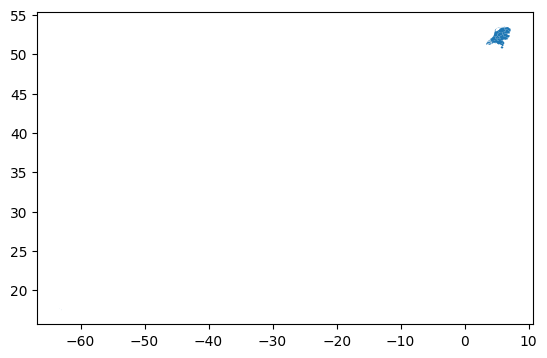

In [38]:
netherlands = df[df.admin == 'Netherlands']
netherlands.plot()

<Axes: >

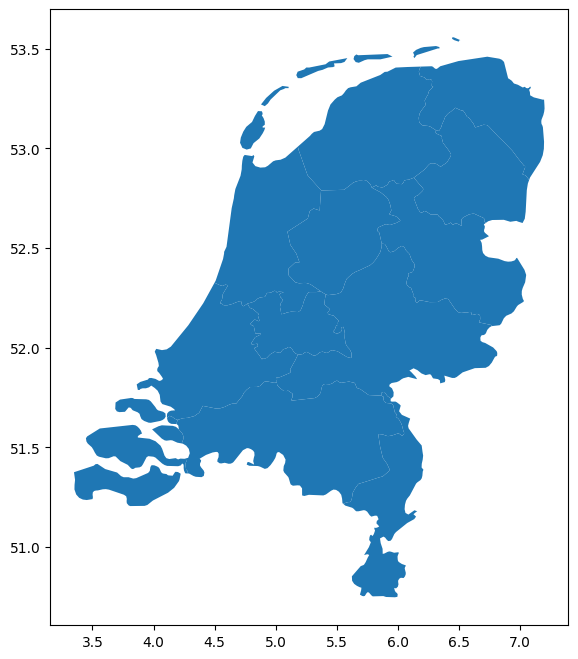

In [39]:
netherlands_copy = apply_bounds(netherlands, (-20, 60), (20, 20))
netherlands_copy.plot(figsize=(8, 8))

#### UK

<Axes: >

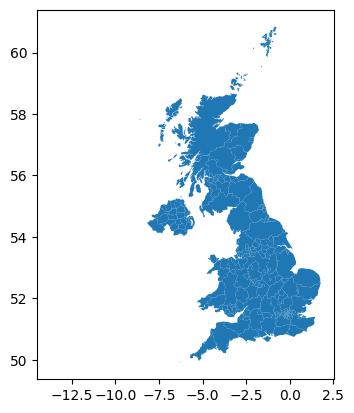

In [40]:
uk = df[df.admin == 'United Kingdom']
uk.plot()

<Axes: >

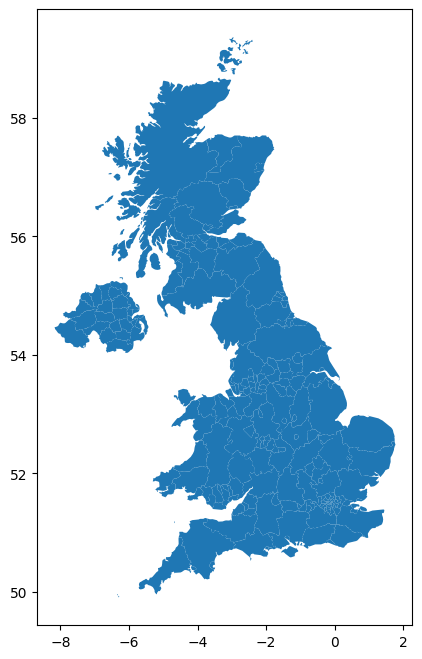

In [41]:
uk_copy = apply_bounds(uk, (-10, 60), (20, 20))
uk_copy.plot(figsize=(8, 8))

### Philippines
- Merges highly urbanized cities (HUCs) into their respective geographic provinces
- Updates provinces:
    - Forms Maguindanao del Norte and Maguindanao del Sur from the former Maguindanao province
    - Splits off Davao Occidental from Davao del Sur
    - Renames Compostella Valley to Davao de Oro

In [42]:
ph_url = "https://raw.githubusercontent.com/jdruii/phgeojson/main/philippines.geojson"
philippines_copy = gpd.read_file(ph_url)

<Axes: >

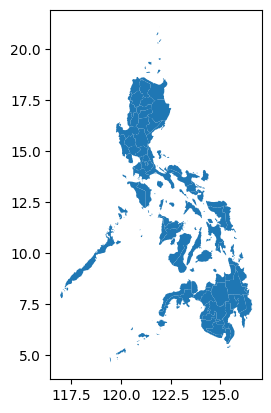

In [43]:
philippines_copy = philippines_copy.rename(columns={'NAME_1': 'name','ISO': 'iso_3166_2'})
philippines_copy.plot()

#### Philippines Regions
- Adds regional map
    - Fixes outdated names

In [44]:
philippines_regions = df[df.admin == 'Philippines'][['geometry','region_cod','region']]

In [45]:
philippines_regions = philippines_regions.dissolve(by=['region_cod', 'region']).reset_index()
philippines_regions = philippines_regions.rename(columns={'region': 'name', 'region_cod': 'iso_3166_2'})

In [46]:
philippines_regions['name'].replace({'Dinagat Islands (Region XIII)': 'Caraga Administrative Region (Region XIII)', 
                                     'Autonomous Region in Muslim Mindanao (ARMM)': 'Bangsamoro Autonomous Region in Muslim Mindanao (BARMM)'}, 
                                    inplace=True)

<Axes: >

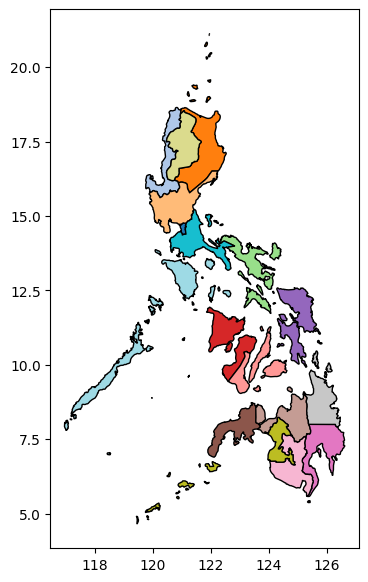

In [47]:
philippines_regions.plot(figsize = (10, 7), edgecolor='black', column='iso_3166_2', legend=False, cmap='tab20')

## Output GeoJSON

In [48]:
alt_maps = {
    "finland": finland_copy,
    "china": china_copy,
    "usa": usa_copy,
    "france": france_copy,
    "france_regions": france_regions,
    "turkey_regions": turkey_regions,
    "italy_regions": italy_regions,
    "philippines_regions": philippines_regions,
    "netherlands": netherlands_copy,
    "norway": norway_copy,
    "uk": uk_copy,
    "russia": russia_copy,
    "spain": spain_copy,
    "portugal": portugal_copy,
    "ukraine": ukraine_with_crimea
}

/var/folders/qb/g_y12hgx11q6zfl1y75kmn2c0000gn/T/ipykernel_84809/1280406611.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


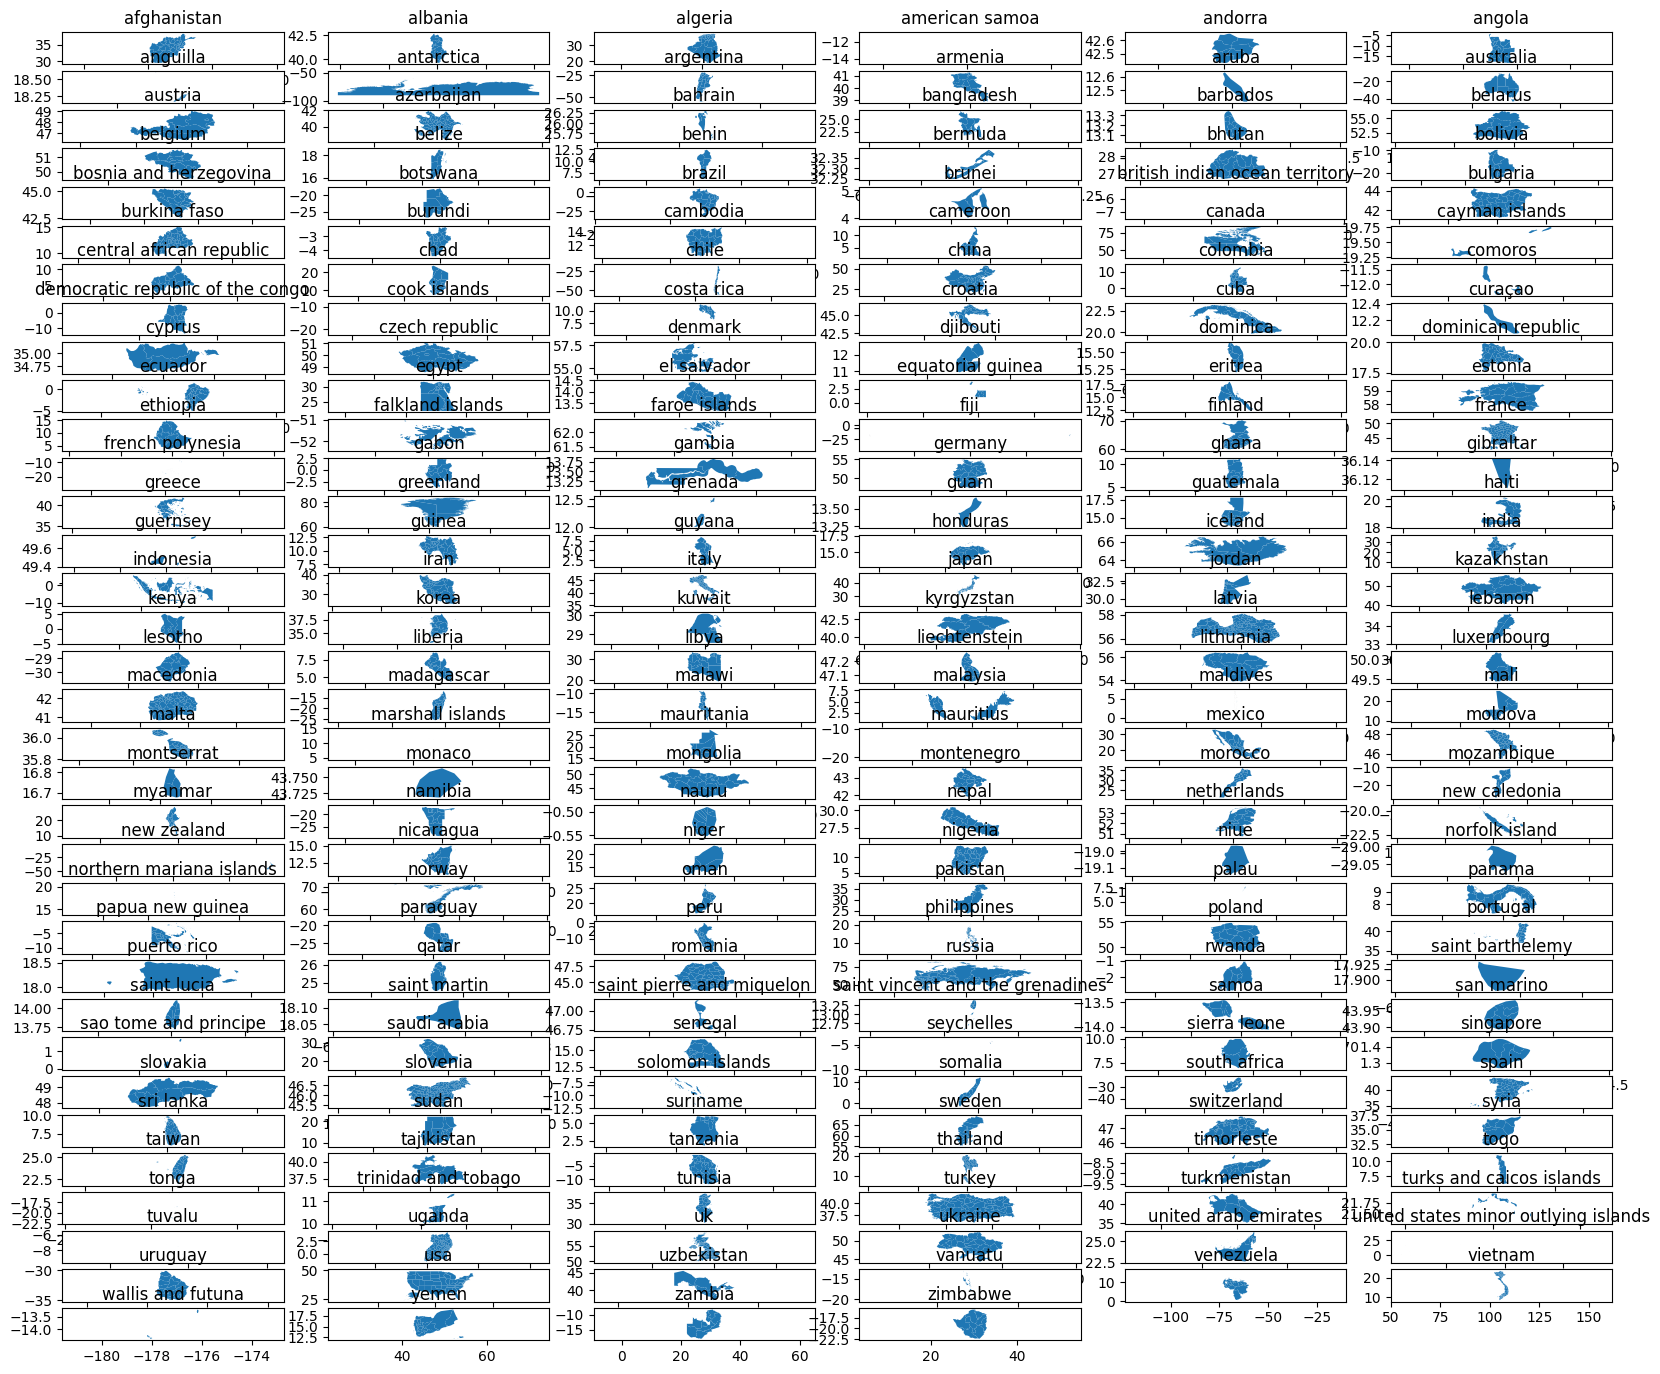

In [49]:
plot_all_countries()

In [50]:
simplify_factors = {
    "uk": 0.005,
}
useful_columns = ["ISO", "NAME_1", "geometry"]

def get_simplify_factor_by_size(gdf):
    xmin, ymin, xmax, ymax = shapely.ops.unary_union(gdf["geometry"]).bounds
    size = (xmax - xmin) * (ymax - ymin)
    print("Size", round(size, 3), end="\t")
    if size > 1000: return 0.03
    if size > 300: return 0.02
    if size > 100: return 0.01
    return 0

def simplify_if_needed(country, gdf):
    """Simplify the maps based on country size"""
    country_alias = country_name_aliases.get(country, country)
    if country_alias in df_50m["admin"].str.lower().unique():
        return

    factor = simplify_factors.get(country) or get_simplify_factor_by_size(gdf)

    if factor:
        gdf["geometry"] = gdf.simplify(factor)

def save_geojson(country):
    if country in custom_countries:
        shutil.copy(f"../src/countries_custom/{country}.geojson", f"../src/countries/{country}.geojson")
    else:
        gdf = get_gdf(country)
        print(country, end="\t")
    
        # For backward compatibility
        gdf["ISO"] = gdf["iso_3166_2"]
        gdf["NAME_1"] = gdf["name"]
    
        simplify_if_needed(country, gdf)
    
        print(f'Saving geojson for {country}...')
        filename_country = country.replace(' ', '_')
        gdf[useful_columns].to_file(f"../src/countries/{filename_country}.geojson", driver="GeoJSON")

for country in countries:
    save_geojson(country)

print("Done.                          ")

afghanistan	Size 130.904	Saving geojson for afghanistan...
albania	Size 5.325	Saving geojson for albania...
algeria	Size 374.167	Saving geojson for algeria...
american samoa	Size 10.187	Saving geojson for american samoa...
andorra	Size 0.079	Saving geojson for andorra...
angola	Size 169.034	Saving geojson for angola...
anguilla	Size 0.217	Saving geojson for anguilla...
antarctica	Size 10614.165	Saving geojson for antarctica...
argentina	Size 662.347	Saving geojson for argentina...
armenia	Size 7.684	Saving geojson for armenia...
aruba	Size 0.04	Saving geojson for aruba...
australia	Saving geojson for australia...
austria	Size 20.068	Saving geojson for austria...
azerbaijan	Size 20.466	Saving geojson for azerbaijan...
bahrain	Size 0.311	Saving geojson for bahrain...
bangladesh	Size 27.194	Saving geojson for bangladesh...
barbados	Size 0.067	Saving geojson for barbados...
belarus	Size 47.021	Saving geojson for belarus...
belgium	Size 7.709	Saving geojson for belgium...
belize	Size 3.795	

## Output Typescript & JSON for Docs Site

In [51]:


# Function to convert country name to a valid JavaScript identifier
def to_js_identifier(name):
    return name.replace(' ', '_').replace('-', '_')

# License boilerplate
license_boilerplate = """/*
 * Licensed to the Apache Software Foundation (ASF) under one
 * or more contributor license agreements.  See the NOTICE file
 * distributed with this work for additional information
 * regarding copyright ownership.  The ASF licenses this file
 * to you under the Apache License, Version 2.0 (the
 * "License"); you may not use this file except in compliance
 * with the License.  You may obtain a copy of the License at
 *
 *   http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing,
 * software distributed under the License is distributed on an
 * "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
 * KIND, either express or implied.  See the License for the
 * specific language governing permissions and limitations
 * under the License.
 */
"""

# Generate TypeScript import statements
imports = "\n".join([f"import {to_js_identifier(country)} from './countries/{to_js_identifier(country)}.geojson';" for country in countries])

# Generate the export object
exports = "export const countries = {\n  " + ",\n  ".join([to_js_identifier(country) for country in countries]) + ",\n};"

# Additional exports
additional_exports = """
export const countryOptions = Object.keys(countries).map(x => {
  if (x === 'uk' || x === 'usa') {
    return [x, x.toUpperCase()];
  }
  if (x === 'italy_regions') {
    return [x, 'Italy (regions)'];
  }
  if (x === 'france_regions') {
    return [x, 'France (regions)'];
  }
  if (x === 'turkey_regions') {
    return [x, 'Turkey (regions)'];
  }
  return [
    x,
    x
      .split('_')
      .map(e => e[0].toUpperCase() + e.slice(1))
      .join(' '),
  ];
});

export default countries;
"""

# Combine license, imports, exports, and additional exports
typescript_code = f"{license_boilerplate}\n{imports}\n\n{exports}\n{additional_exports}"

# Write to a file
with open("../src/countries.ts", "w") as file:
    file.write(typescript_code)

print("TypeScript code written to src/countries.ts")

# DOCS JSON:
# Replace underscores with spaces and title-case each country name
formatted_countries = [country.replace("_", " ") for country in countries]
formatted_countries = [country.upper() if country in {"usa", "uk"} else country.title() for country in formatted_countries]
formatted_countries = [country.replace(" Regions"," (regions)") for country in formatted_countries]


# Create a dictionary in the desired format
data = {"countries": formatted_countries}
# Convert the dictionary to a JSON string with proper formatting
json_data = json.dumps(data, indent=2) + "\n"

# Write to a file
with open("../../../../docs/data/countries.json", "w") as file:
    file.write(json_data)

print("JSON written to docs/data/countries.json")

TypeScript code written to src/countries.ts
JSON written to docs/data/countries.json
